In [4]:
ORGINAL_DATASET_PATH = r"C:\Users\shubh\OneDrive\Desktop\dsp_cry_corpus\dont_cry_corpus"
DATASET_PATH = r"C:\Users\shubh\OneDrive\Desktop\dsp_cry_corpus\dont_cry_corpus"
ORGINAL_AUDIO_DATASET = "./dataset"
AUG_AUDIO_DATASET = r"C:\Users\shubh\OneDrive\Desktop\dsp_cry_corpus\augmented_data"
FEATURES_FOLDER = r"C:\Users\shubh\OneDrive\Desktop\dsp_cry_corpus\features"
DATASET_MFCC_PATH = f"{FEATURES_FOLDER}/mfcc"
DATASET_RMS_PATH = f"{FEATURES_FOLDER}/rms"
DATASET_ZCR_PATH = f"{FEATURES_FOLDER}/zcr"
ARTICLE_RESULTS = r"C:\Users\shubh\OneDrive\Desktop\dsp_cry_corpus\article"

In [5]:
targetSampleRate = 22050
duration = 7.0
targetNumSamples = int(targetSampleRate * duration)

In [6]:
import os
import warnings
warnings.filterwarnings('ignore')
import wave
import random
import librosa
import numpy as np
import soundfile as sf
from pydub.playback import play
from audiomentations import Compose, AddGaussianNoise, PitchShift, HighPassFilter
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa.display as dsp
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torchsummary import summary
import os
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv
from torch import nn
from torchvision import datasets
# from torch.utils.tensorboard import SummaryWriter
import torchvision
import tensorflow as ts


plt.rcParams["axes.labelsize"] = 'medium'
plt.rcParams["axes.titlecolor"] = 'red'
plt.rcParams["axes.titlesize"] = 'large'
plt.rcParams["font.size"] = 18

class audioPreprocessing:


    def __init__(self, sample_rate = None, num_samples = None, duration = None):
        self.signal = None
        self.sample_rate = sample_rate
        self.num_samples = num_samples
        self.duration = duration

    def readAudio(self, fileName, dur=60):
      self.signal, self.sample_rate = librosa.load(fileName, sr=22050)
      # Optional: Check if self.signal is valid (e.g., not None)
      self.num_samples = self.signal.shape[0]
      self.duration = librosa.get_duration(y=self.signal,sr=self.sample_rate)
      return self.signal


    def add_white_noise(self, signal, noise_percentage_factor):
        noise = np.random.normal(0, signal.std(), signal.size)
        augmented_signal = signal + noise * noise_percentage_factor
        return augmented_signal


    def time_stretch(self, signal, time_stretch_rate):
        """Time stretching implemented with librosa:
        https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html?highlight=pitch%20shift#librosa.effects.pitch_shift
        """
        return librosa.effects.time_stretch(signal, time_stretch_rate)


    def pitch_scale(self, signal, sr, num_semitones):
        """Pitch scaling implemented with librosa:
        https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html?highlight=pitch%20shift#librosa.effects.pitch_shift
        """
        return librosa.effects.pitch_shift(signal, sr, num_semitones)


    def random_gain(self, signal, min_factor=0.1, max_factor=0.12):
        gain_rate = random.uniform(min_factor, max_factor)
        augmented_signal = signal * gain_rate
        return augmented_signal


    def invert_polarity(self, signal):
        return signal * -1


    def _resample_if_necessary(self, signal, targetSampleRate):
        if targetSampleRate != self.sample_rate:
            resampler = torchaudio.transforms.Resample(self.sample_rate, targetSampleRate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _cut_if_necessary(self, signal, targetNumSamples = None):
        if targetNumSamples is None:
            if signal.shape[1] > self.num_samples:
                signal = signal[:, :self.num_samples]
        else:
            if signal.shape[1] > targetNumSamples:
                signal = signal[:, :targetNumSamples]

        return signal

    def _right_pad_if_necessary(self, signal, targetNumSamples = None):
        length_signal = signal.shape[1]
        if targetNumSamples is None:
            if length_signal < self.num_samples:
                num_missing_samples = self.num_samples - length_signal
                last_dim_padding = (0, num_missing_samples)
                signal = torch.nn.functional.pad(signal, last_dim_padding)
        else:
            if length_signal < targetNumSamples:
                num_missing_samples = targetNumSamples - length_signal
                last_dim_padding = (0, num_missing_samples)
                signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal


    def audioAugmentation(self, signal):
        
        augment_raw_audio = Compose(
            [
                AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.015, p=1),
                PitchShift(min_semitones=-2, max_semitones=2, p=1),
                HighPassFilter(min_cutoff_freq=3000, max_cutoff_freq=4000, p=1)
            ]
        )
        augmented_signal = augment_raw_audio(signal, self.sample_rate)
        return augmented_signal

    def audioAugmentation1(self, signal, i):
        
        aug_transform = []
        aug_transform1 = [
                AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.015, p=1),
                PitchShift(min_semitones=-2, max_semitones=2, p=1),
                HighPassFilter(min_cutoff_freq=3000, max_cutoff_freq=4000, p=1)
            ]
        for j in i:
            aug_transform.append(aug_transform1[j])


        augment_raw_audio = Compose(aug_transform)
        augmented_signal = augment_raw_audio(signal, self.sample_rate)
        return augmented_signal


    def plotSpectrum(self, signal, sample_rate, plotType = 'linear', title = "", ax = None):
            if ax is None:
                fig, ax = plt.subplots(1, 1, sharex=True, figsize=(9,5))

            d = librosa.stft(signal)
            D = librosa.amplitude_to_db(np.abs(d),ref=np.max)
            dsp.specshow(D, y_axis = plotType, x_axis ='s', sr=sample_rate, ax = ax)
            ax.set(title = title)
            ax.label_outer()
#             fig.colorbar(img, ax = ax, format='%+2.f dB')

    def plotBeforeAfter(self, signal, augmented, sample_rate):
        fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = (15,10))
        librosa.display.waveshow(signal, sr = sample_rate,ax = ax[0])
        ax[0].axis('off')
        ax[0].set(title = 'Original Signal')

        librosa.display.waveshow(augmented, sr = sample_rate, ax = ax[1])
        ax[1].set(title = 'Augmented Signal')
        ax[1].axis('off')

        plt.show()

In [ ]:
import shutil
if os.path.exists('dataset'):
    shutil.rmtree('dataset')
shutil.copytree(r'C:\Users\shubh\OneDrive\Desktop\dsp_cry_corpus\dont_cry_corpus', 'dataset')


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import soundfile as sf
import os
import warnings
warnings.filterwarnings('ignore')
import wave
import random
import librosa
import numpy as np
import soundfile as sf
from pydub.playback import play
from audiomentations import Compose, AddGaussianNoise, PitchShift, HighPassFilter
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa.display as dsp
import pandas as pd
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv
import pathlib
from tqdm.auto import tqdm

plt.rcParams["axes.labelsize"] = 'medium'
plt.rcParams["axes.titlecolor"] = 'red'
plt.rcParams["axes.titlesize"] = 'large'
plt.rcParams["font.size"] = 18

obj = audioPreprocessing()

def load_data(path):
    audioFiles = sorted(list(pathlib.Path(path).rglob("*.wav")))
    classes = [str(f.parent).split(os.path.sep)[-1] for f in audioFiles]  # Extract class label from parent directory
    return audioFiles, classes

def augment_data(audioFileNames, classes, save_path):
    global obj
    dictionary = {'belly_pain': 16,
                  'burping': 8,
                  'discomfort': 27,
                  'hungry': 382,
                  'tired': 24}
    print("before: ", len(audioFileNames))
    for idx, x in tqdm(enumerate(audioFileNames), total=len(audioFileNames)):
        signal_org = obj.readAudio(fileName=x)
        cc = pathlib.Path(f"{save_path}//" + "//".join(str(x).split(os.path.sep)[1:]))
        path2save = os.path.join(cc.parent, cc.stem + cc.suffix)
        pathlib.Path(pathlib.Path(path2save).parent).mkdir(parents=True, exist_ok=True)
        if classes[idx] == "hungry":
            sf.write(os.path.join(pathlib.Path(path2save).parent, x.name), signal_org, targetSampleRate)
        else:
            augmentation_num = 382 // dictionary[classes[idx]]
            print(augmentation_num)
            signal = signal_org
            for i in range(augmentation_num):
                path2save = os.path.join(cc.parent, cc.stem + "_" + str(idx) + str(i) + cc.suffix)
                augmented_signal = obj.audioAugmentation1(signal, [0])
                pathlib.Path(cc.parent).mkdir(parents=True, exist_ok=True)
                sf.write(path2save, augmented_signal, obj.sample_rate)
                sf.write(os.path.join(pathlib.Path(path2save).parent, x.name), signal_org, targetSampleRate)
    print("After:", len(list(pathlib.Path(save_path).rglob("*.wav"))))

if __name__ == "__main__":
    np.random.seed(42)
    X, y = load_data(ORGINAL_AUDIO_DATASET)
    print(f"Train: {len(X)} - {len(y)}")
    augment_data(X, y, AUG_AUDIO_DATASET)


In [7]:
import matplotlib.pyplot as plt
import pathlib
import cv2
import numpy as np
import librosa
import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

def generate_spectrogram(stft_matrix, Fs):
    stft_matrix = np.abs(stft_matrix.T)
    
    fig = plt.figure(figsize=(2.56, 2.56), facecolor='lightgrey')

    ax = fig.add_subplot(1, 1, 1)
    powerSpectrum, frequenciesFound, time, imageAxis = ax.specgram(stft_matrix, Fs=Fs)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    
    plt.axis('on')
    return fig



def extract_features(DATASET_FILE, features_folder):
    saveTo = f"{features_folder}/spectrogram/"
    pathlib.Path(saveTo).mkdir(parents=True, exist_ok=True)

    files = sorted(list(pathlib.Path(DATASET_FILE).rglob("*.wav")))
    stft_db_matrices = []  # List to store STFT matrices and class labels
    for f in tqdm(files, total=len(files)):
        class_label = f.parts[-2]  # Extract class label from the folder name
        pathlib.Path(os.path.join(saveTo, class_label)).mkdir(parents=True, exist_ok=True)

        signal, sr = librosa.load(f, duration=5.0)
        stft_matrix = librosa.stft(signal,n_fft=2046,hop_length=2046)
        #print((len(stft_matrix)))
        stft_db = librosa.amplitude_to_db(np.abs(stft_matrix), ref=1)
        #print("Shape of stft_db before reshaping:", stft_db.shape)
        stft_db = stft_db.reshape(128,432,1)
        stft_db_matrices.append((stft_db, class_label))  # Store both STFT matrix and class label
        
        # spectrogram = generate_spectrogram(stft_matrix, sr)
        # spectrogram.savefig(os.path.join(saveTo, class_label, f.stem + ".png"))

    return stft_db_matrices


if __name__ == "__main__":
    stft_db_matrices = extract_features(AUG_AUDIO_DATASET, FEATURES_FOLDER)


100%|██████████| 1939/1939 [00:22<00:00, 87.70it/s] 


In [ ]:
print((stft_db_matrices))

In [8]:
def separate_arrays_and_labels(stft_db_matrices):
    db_arrays = []
    labels = []

    for stft_db_array, label in stft_db_matrices:
        db_arrays.append(stft_db_array)
        labels.append(label)

    return db_arrays, labels


db_arrays, labels = separate_arrays_and_labels(stft_db_matrices)


In [9]:
import numpy as np


db_arrays_np = np.array(db_arrays)
labels_np = np.array(labels)


In [ ]:
print(labels)

In [61]:
print(len(db_arrays_np))

1939


In [62]:
print(len(labels_np))

1939


In [10]:
import pandas as pd
import os
import cv2
from PIL import Image
import pathlib
import math
import librosa
from tqdm.auto import tqdm

def generate(where, stft_db_matrices):
    wanted_size = (600, 600)
    border_white = (255, 255, 255)
    border_black = (255, 255, 255)

    A = []
    B = []
    C = []

    ALGS = [
        "spectrogram"  # Change this to "mel_spectrogram" if you want Mel spectrograms
    ]

    for alg in ALGS:
        A = []
        for stft_db, lbl in stft_db_matrices:
            if lbl not in ["belly_pain", "burping", "discomfort", "hungry", "tired"]:
                continue
                
            # Here, you can modify the path based on the folder structure of your features
            xx = sorted(list(pathlib.Path(f"{FEATURES_FOLDER}/{alg}/{lbl}").rglob("*.png")))
            a = cv2.imread(str(xx[0]))
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
            # a = add_margin(Image.fromarray(255 * to3D(a)), 5, 5, 5, 5, color=border_white)
            A.append(255 * np.asarray(a))

        res1 = np.concatenate(A, axis=1)
        res1 = cv2.cvtColor(res1, cv2.COLOR_BGR2RGB)
        parts = alg.split("_")
        if "dataset" in parts:
            z = "_".join(parts[0:parts.index("dataset")])
        else:
            z = alg
        cv2.imwrite(f"{where}/tsi_{z}.png", res1)

if __name__ == "__main__":
    pathlib.Path(f'{ARTICLE_RESULTS}').mkdir(parents=True, exist_ok=True)
    generate(f'{ARTICLE_RESULTS}', stft_db_matrices)


In [11]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import keras
from keras import backend as K

In [24]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

if len(labels_np.shape) > 1:
    labels_np = labels_np.ravel()


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_np)


y_onehot = to_categorical(y_encoded)


x = db_arrays_np


x_train, x_temp, y_train, y_temp = train_test_split(x, y_onehot, train_size=0.8, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.33, random_state=42)


model = Sequential()
model.add(InputLayer(input_shape=x[0].shape))
model.add(Conv2D(32, 3, activation='relu' ))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(y_onehot.shape[1], activation='softmax'))  


learning_rate = 0.0001 
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=4, epochs=10)


Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 145s 368ms/step - accuracy: 0.4443 - loss: 2.0614 - val_accuracy: 0.7375 - val_loss: 0.6981
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 143s 368ms/step - accuracy: 0.7667 - loss: 0.6098 - val_accuracy: 0.8185 - val_loss: 0.4752
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 145s 374ms/step - accuracy: 0.8663 - loss: 0.3929 - val_accuracy: 0.8494 - val_loss: 0.5934
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 142s 366ms/step - accuracy: 0.9182 - loss: 0.2628 - val_accuracy: 0.9459 - val_loss: 0.2454
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 140s 360ms/step - accuracy: 0.9683 - loss: 0.1088 - val_accuracy: 0.9421 - val_loss: 0.2417
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 140s 360ms/step - accuracy: 0.9728 - loss: 0.0891 - val_accuracy: 0.9537 - val_loss: 0.1724
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 134s 344ms/step - accuracy: 0.9801 - loss: 0.0675 - val_accuracy: 0.9614 - val_loss: 0.1010
Epoch 8/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 135s 349ms/step - accuracy: 0.9897 -

In [25]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print("Testing Loss:", test_loss)
print("Testing Accuracy:", test_accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.9285 - loss: 0.5640
Testing Loss: 0.38239726424217224
Testing Accuracy: 0.9457364082336426


In [26]:
def predict_label(audio_file):
    label = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired'] 
    labels = np.array(label) 
    processed_audio = preprocess_audio(audio_file)
    predicted_prob = model.predict(np.array([processed_audio]))
    predicted_label_index = np.argmax(predicted_prob)
    predicted_label = labels[predicted_label_index]
    return predicted_label

[]

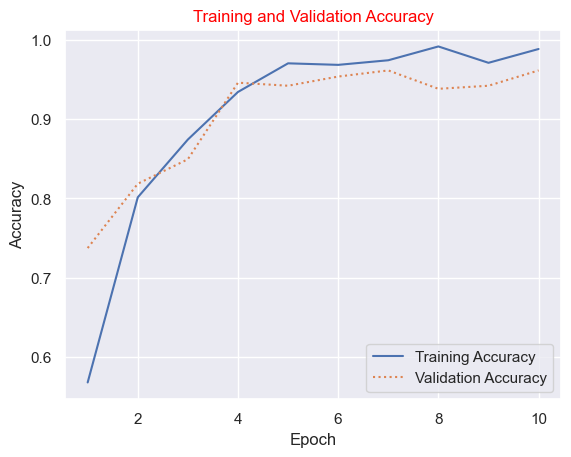

In [27]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
# test_acc = hist.history['test_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.plot()

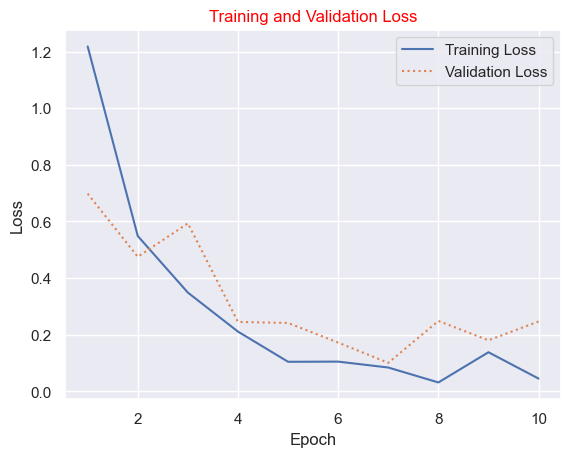

In [28]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure()

plt.plot(epochs, loss, '-', label='Training Loss')
plt.plot(epochs, val_loss, ':', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step


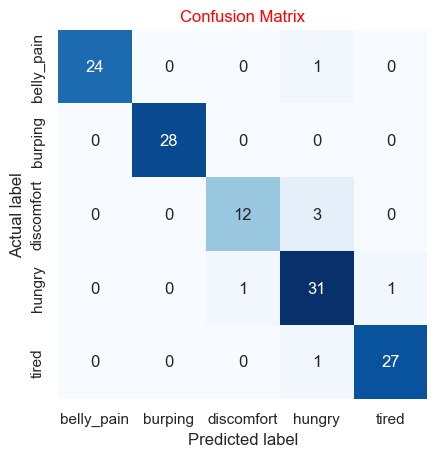

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


y_predicted = model.predict(x_test)
predicted_labels = np.argmax(y_predicted, axis=1)
actual_labels = np.argmax(y_test, axis=1)
class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

mat = confusion_matrix(actual_labels, predicted_labels)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
from sklearn.metrics import classification_report

# Convert probabilities to class labels
predicted_labels = np.argmax(y_predicted, axis=1)

# Print classification report
print(classification_report(actual_labels, predicted_labels, target_names=class_labels))


              precision    recall  f1-score   support

  belly_pain       1.00      0.96      0.98        25
     burping       1.00      1.00      1.00        28
  discomfort       0.92      0.80      0.86        15
      hungry       0.86      0.94      0.90        33
       tired       0.96      0.96      0.96        28

    accuracy                           0.95       129
   macro avg       0.95      0.93      0.94       129
weighted avg       0.95      0.95      0.95       129



In [20]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Calculate specificity
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("Specificity:", specificity)


Specificity: 1.0


In [31]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Calculate specificity for each class label
specificity_per_class = []
for i in range(len(class_labels)):
    true_negatives = sum(cm[j, j] for j in range(len(class_labels)) if j != i)
    false_positives = sum(cm[j, i] for j in range(len(class_labels)) if j != i)
    specificity = true_negatives / (true_negatives + false_positives)
    specificity_per_class.append(specificity)

# Print specificity for each class label
for i, label in enumerate(class_labels):
    print(f" {label}: {specificity_per_class[i]}")


 belly_pain: 1.0
 burping: 1.0
 discomfort: 0.990990990990991
 hungry: 0.9479166666666666
 tired: 0.9895833333333334


In [33]:
from keras.models import load_model
model.save('dsp_cry_corpus_cnn.h5')

In [32]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam




model = Sequential()
model.add(InputLayer(input_shape=x[0].shape))
model.add(Conv2D(32, 3, activation='relu' ))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(y_onehot.shape[1], activation='softmax'))  


learning_rate = 0.0001 
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 430, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 215, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 213, 128)   │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 106, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 104, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 19200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    19,661,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,999,429 (76.29 MB)

 Trainable params: 19,999,429 (76.29 MB)

 Non-trainable params: 0 (0.00 B)